## Load data

In [14]:
import pickle

training_file = 'traffic-signs-data/train.p'
validation_file = 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

## Data set summary

In [15]:
import numpy as np

n_train = y_train.shape[0]
n_validation = y_valid.shape[0]
n_test = y_test.shape[0]
image_shape = X_train.shape[1:]
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


## Data visualization

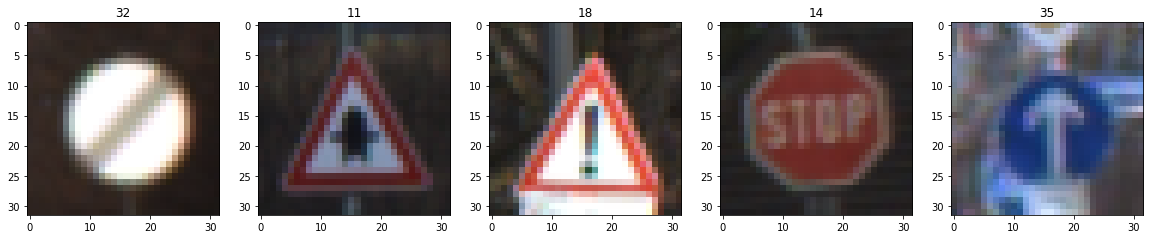

In [16]:
import matplotlib.pyplot as plt
import random
%matplotlib inline

fig, ax = plt.subplots(1, 5, figsize=(20,4))
indices = []

for i in range(5):
    index = random.randint(0, n_train)
    indices.append(index)
    image = X_train[index].squeeze()
    ax[i].imshow(image, cmap="gray")
    ax[i].set_title(y_train[index])

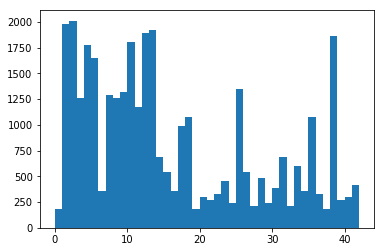

In [20]:
plt.hist(y_train, bins=np.arange(0,n_classes))
plt.show()

## Data preprocessing

In [21]:
X_train = np.mean(X_train, axis=3, keepdims=True)
X_valid = np.mean(X_valid, axis=3, keepdims=True)
X_test = np.mean(X_test, axis=3, keepdims=True)

X_train = (X_train - 128) / 128
X_valid = (X_valid - 128) / 128
X_test = (X_test - 128) / 128

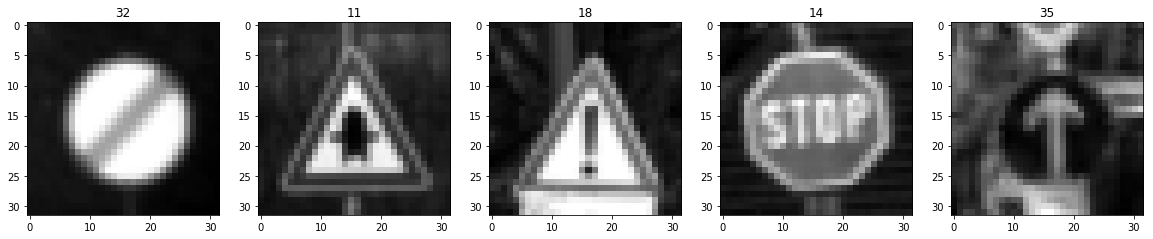

In [22]:
fig, ax = plt.subplots(1, 5, figsize=(20,4))

for i, index in enumerate(indices):
    image = X_train[index].squeeze()
    ax[i].imshow(image, cmap="gray")
    ax[i].set_title(y_train[index])

## Model Architecture

In [23]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def Inception(x):
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x32.
    w1 = tf.Variable(tf.truncated_normal(shape=(5,5,1,32), mean=mu, stddev=sigma), name='w1')
    b1 = tf.Variable(tf.zeros(32), name='b1')
    layer1 = tf.nn.conv2d(x, w1, strides=[1,1,1,1], padding='VALID') + b1
    
    # Activation & Max pool. Output = 14x14x32.
    layer1 = tf.nn.relu(layer1)
    layer1 = tf.nn.max_pool(layer1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # Layer 2: Convolutional. Input = 14x14x32. Output = 10x10x64.
    w2 = tf.Variable(tf.truncated_normal(shape=(5,5,32,64), mean=mu, stddev=sigma), name='w2')
    b2 = tf.Variable(tf.zeros(64), name='b2')
    layer2 = tf.nn.conv2d(layer1, w2, strides=[1,1,1,1], padding='VALID') + b2
    
    # Activation & Max pool. Output = 5x5x64.
    layer2 = tf.nn.relu(layer2)
    layer2 = tf.nn.max_pool(layer2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # Layer 3: Convolutional. Input = 5x5x64. Output = 3x3x128.
    w3 = tf.Variable(tf.truncated_normal(shape=(3,3,64,128), mean=mu, stddev=sigma), name='w3')
    b3 = tf.Variable(tf.zeros(128), name='b3')
    layer3 = tf.nn.conv2d(layer2, w3, strides=[1,1,1,1], padding='VALID') + b3
    
    # Activation & Max pool. Output = 2x2x128.
    layer3 = tf.nn.relu(layer3)
    layer3 = tf.nn.max_pool(layer3, ksize=[1,2,2,1], strides=[1,1,1,1], padding='VALID')
    
    # Max pool, Flatten, Concat, & Dropout. Output = 1920
    layer1 = tf.nn.max_pool(layer1, ksize=[1,4,4,1], strides=[1,2,2,1], padding='VALID')
    layer2 = tf.nn.max_pool(layer2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    fc0 = tf.concat([flatten(layer1), flatten(layer2), flatten(layer3)], 1)
    fc0 = tf.nn.dropout(fc0, keep_prob)
    
    # Layer 4: Fully connected layer. Input = 1920. Output = 800.
    w4 = tf.Variable(tf.truncated_normal(shape=(1920,800), mean=mu, stddev=sigma), name='w4')
    b4 = tf.Variable(tf.zeros(800), name='b4')
    layer4 = tf.matmul(fc0, w4) + b4
    layer4 = tf.nn.relu(layer4)
    
    # Layer 5: Fully connected layer. Input = 800. Output = 43.
    w5 = tf.Variable(tf.truncated_normal(shape=(800,43), mean=mu, stddev=sigma), name='w5')
    b5 = tf.Variable(tf.zeros(43), name='b5')
    logits = tf.matmul(layer4, w5) + b5
    
    return logits

## Train, validate and test model

In [24]:
from sklearn.utils import shuffle

EPOCHS = 20
BATCH_SIZE = 128
rate = 0.0005

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

In [25]:
logits = Inception(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [26]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [27]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.800

EPOCH 2 ...
Validation Accuracy = 0.897

EPOCH 3 ...
Validation Accuracy = 0.911

EPOCH 4 ...
Validation Accuracy = 0.937

EPOCH 5 ...
Validation Accuracy = 0.960

EPOCH 6 ...
Validation Accuracy = 0.933

EPOCH 7 ...
Validation Accuracy = 0.935

EPOCH 8 ...
Validation Accuracy = 0.954

EPOCH 9 ...
Validation Accuracy = 0.956

EPOCH 10 ...
Validation Accuracy = 0.951

EPOCH 11 ...
Validation Accuracy = 0.953

EPOCH 12 ...
Validation Accuracy = 0.959

EPOCH 13 ...
Validation Accuracy = 0.948

EPOCH 14 ...
Validation Accuracy = 0.962

EPOCH 15 ...
Validation Accuracy = 0.971

EPOCH 16 ...
Validation Accuracy = 0.953

EPOCH 17 ...
Validation Accuracy = 0.960

EPOCH 18 ...
Validation Accuracy = 0.972

EPOCH 19 ...
Validation Accuracy = 0.970

EPOCH 20 ...
Validation Accuracy = 0.962

Model saved


In [29]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    train_accuracy = evaluate(X_train, y_train)
    valid_accuracy = evaluate(X_valid, y_valid)
    test_accuracy = evaluate(X_test, y_test)
    print("Training Accuracy = {:.3f}".format(train_accuracy))
    print("Validation Accuracy = {:.3f}".format(valid_accuracy))
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Training Accuracy = 0.999
Validation Accuracy = 0.962
Test Accuracy = 0.940


## Test images

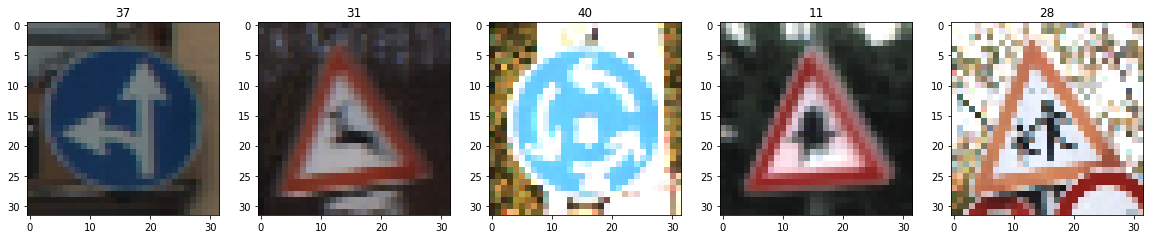

In [36]:
import matplotlib.image as mpimg
import cv2
import os

path = 'test_images/'
images = []
labels = [37, 31, 40, 11, 28]

for image_name in os.listdir(path):
    image = mpimg.imread(path + image_name)
    image = cv2.resize(image, (32, 32))
    images.append(image)
    
fig, ax = plt.subplots(1, 5, figsize=(20,4))

for i in range(5):
    ax[i].imshow(images[i], cmap="gray")
    ax[i].set_title(labels[i])

### Predictions

In [37]:
images = np.mean(images, axis=3, keepdims=True)
images = (images - 128) / 128

predict = tf.argmax(logits, 1)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    prediction = sess.run(predict, feed_dict={x: images, y: labels, keep_prob: 1.0})
    print(prediction)

INFO:tensorflow:Restoring parameters from ./lenet
[37 31 40 11 28]


### Accuracy

In [38]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(images, labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 1.000


### Top 5 softmax probabilities

In [39]:
top_k = tf.nn.top_k(tf.nn.softmax(logits), k=5)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    top_5 = sess.run(top_k, feed_dict={x: images, y: labels, keep_prob: 1.0})
    
    for i in range(5):
        print(['%.3f' % j for j in top_5[0][i]])
        
    for i in range(5):
        print(top_5[1][i])

INFO:tensorflow:Restoring parameters from ./lenet
['1.000', '0.000', '0.000', '0.000', '0.000']
['1.000', '0.000', '0.000', '0.000', '0.000']
['1.000', '0.000', '0.000', '0.000', '0.000']
['1.000', '0.000', '0.000', '0.000', '0.000']
['1.000', '0.000', '0.000', '0.000', '0.000']
[37 30 39 40 26]
[31 23 10 21 19]
[40 12 37 35 25]
[11 30 27 23 20]
[28 27 40 30 11]
